<div style="color:red">
    <h3>To-do:</h3>
    <ul>
        <li>Finish descriptions</li>
    </ul>
</div> 

## Ch. 2 - CCI Indicator Strategies (Part I)

#### Introduction - What is "CCI"?

Developed by Donald Lambert and featured in Commodities magazine in 1980, the <b>Commodity Channel Index (CCI)</b> is a versatile indicator that can be used to identify a new trend or warn of extreme conditions. Lambert originally developed CCI to identify cyclical turns in commodities, but the indicator can be successfully applied to indices, ETFs, stocks and other securities. In general, CCI measures the current price level relative to an average price level over a given period of time. CCI is relatively high when prices are far above their average, but is relatively low when prices are far below their average. In this manner, CCI can be used to identify overbought and oversold levels.

In this tutorial, you will learn about:

* CCI correction
* Overbought & Oversold
* Bullish & Bearish Divergence

<hr size="5"/>

### Table of Contents

* [1. Scrapping data with Beautiful Soup](#1.-Scrapping-data-with-Beautiful-Soup)
    * [1.1 Scrapping real-time price for '0001.HK'](#1.1-Scrapping-real-time-price-for-'0001.HK')
    * [1.2 Scrapping data for a list of stock tickers](#1.2-Scrapping-data-for-a-list-of-stock-tickers)
* [2. TO-DO]
* [3. TO-DO]

### 1. CCI Correction

(DESCRIPTION: TO-DO)

TL;DR Buy when CCI surges above +100, sell when it plunges below -100.

 Requirements:
 * [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#installing-beautiful-soup)
 * pandas
 * [requests-html=0.10.0](https://pypi.org/project/requests-html/)

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [22]:
# load aapl csv file
df = pd.read_csv('../../database/nasdaq_ticks_day/nasdaq_AAPL.csv', header=0, index_col='Date', parse_dates=True)

# We select only the data from 2015-2019
df = df.loc[pd.Timestamp('2019-01-01'):pd.Timestamp('2019-12-31')]

df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,151.824944,155.706587,151.178000,154.794983,37039700
2019-01-03,141.130823,142.836396,139.190009,139.376251,91312200
2019-01-04,141.669942,145.610396,140.954392,145.326126,58607100
2019-01-07,145.757453,145.884885,143.012857,145.002686,54777800
2019-01-08,146.600407,148.815694,145.580994,147.766861,41025300


In [23]:
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

signals['Typical price'] = (df['High'] + df['Low'] + df['Close']) / 3
signals['SMA'] = signals['Typical price'].rolling(window=20, min_periods=1, center=False).mean()

signals['mean_deviation'] = signals['Typical price'].rolling(window=20, min_periods=1, center=False).std()

signals['CCI'] = (signals['Typical price'] - signals['SMA']) / (0.015 * signals['mean_deviation'])

# Generate buy signal
signals.loc[signals['CCI'] > 100, 'signal'] = 1.0

# Generate sell signal
signals.loc[signals['CCI'] < -100, 'signal'] = -1.0

signals['positions'] = signals['signal'].diff()

print(signals)

            signal  Typical price         SMA  mean_deviation         CCI  \
Date                                                                        
2019-01-02     0.0     153.893190  153.893190             NaN         NaN   
2019-01-03     0.0     140.467552  147.180371        9.493360  -47.140452   
2019-01-04     0.0     143.963638  146.108127        6.964988  -20.526368   
2019-01-07     0.0     144.633476  145.739464        5.734489  -12.857736   
2019-01-08     0.0     147.387850  146.069141        5.020628   17.510540   
2019-01-09     0.0     149.472429  146.636356        4.700612   40.222745   
2019-01-10     0.0     149.851467  147.095657        4.459802   41.194800   
2019-01-11     0.0     149.482228  147.393979        4.214309   33.034278   
2019-01-14     0.0     147.191811  147.371516        3.942701   -3.038610   
2019-01-15     0.0     149.158776  147.550242        3.759935   28.520600   
2019-01-16     0.0     151.547225  147.913604        3.765070   64.339160   

### 2. Overbought and Oversold

Tl;DR Buy when 14-day CCI falls below -100 and then rises back above, sell when it rises above +100 and then falls back below.

An asset is considered overbought when the 14-day CCI rises above +100 and then falls back below. It’s at that point that a sell signal is generated. On the flip side, when the 14-day CCI falls below -100, and then rises back above, a buy signal is generated.

In [1]:
# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
aapl['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

NameError: name 'plt' is not defined

### 3. Backtesting

In [15]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['AAPL'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(aapl['Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(aapl['Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(aapl['Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
portfolio.head()

,AAPL,holdings,cash,total,returns
Date,,,,,
2015-01-02,0.0,0.0,100000.0,100000.0,NaN
2015-01-05,0.0,0.0,100000.0,100000.0,0.0
2015-01-06,0.0,0.0,100000.0,100000.0,0.0
2015-01-07,0.0,0.0,100000.0,100000.0,0.0
2015-01-08,0.0,0.0,100000.0,100000.0,0.0


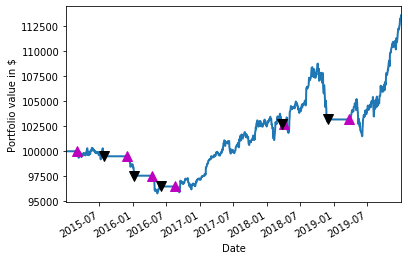

In [16]:
# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

### 4. Evaluate strategy

#### 4.1 Sharpe ratio

In [17]:
# Isolate the returns of your strategy
returns = portfolio['returns']

# annualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(sharpe_ratio)

0.8311190106415088


#### 4.2 Maximum dropdown

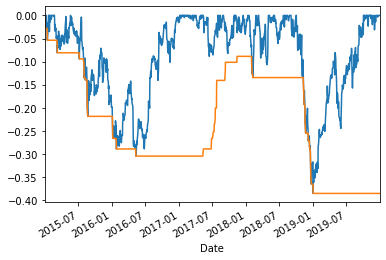

In [19]:
# Define a trailing 252 trading day window
window = 252

# Calculate the max drawdown in the past window days for each day 
rolling_max = aapl['Close'].rolling(window, min_periods=1).max()
daily_drawdown = aapl['Close']/rolling_max - 1.0

# Calculate the minimum (negative) daily drawdown
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

# Plot the results
daily_drawdown.plot()
max_daily_drawdown.plot()

# Show the plot
plt.show()

#### 3. Compound Annual Growth Rate (CAGR)

In [21]:
# Get the number of days in `aapl`
days = (aapl.index[-1] - aapl.index[0]).days

# Calculate the CAGR 
cagr = ((((aapl['Close'][-1]) / aapl['Close'][1])) ** (365.0/days)) - 1

# Print the CAGR
print(cagr)

0.24654176746201206


### References:
* [StockCharts - Commodity Channel Index (CCI)](https://school.stockcharts.com/doku.php?id=technical_indicators:commodity_channel_index_cci)
* [CCI Indicator strategy comparison](https://investsomemoney.com/cci-indicator-strategy/)